# Phase 2: Trajectory Prediction with Auxiliary Depth Estimation

# 🧭 Introduction

"""
Welcome to **Phase 2** of the DLAV Projec! 🚗💨

In this phase, you'll work with a more challenging dataset that includes:
- RGB **camera images**
- Ground-truth **depth maps**
- Ground-truth **semantic segmentation** labels

Your goal is still to predict the **future trajectory** of the self-driving car (SDC), but you now have more tools at your disposal! 🎯

Here, we provide an example where **depth estimation** is used as an auxiliary task to improve trajectory prediction.

However, you're **free to explore** other auxiliary tasks (e.g., using semantic labels), different loss functions, data augmentations, or better architectures! 💡

This notebook will walk you through loading the dataset, building a model, training with and without the auxiliary task, and visualizing results.
"""

In [ ]:
# Install gdown to handle Google Drive file download
!pip install -q gdown

import gdown
import zipfile

download_url = f"https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr"
output_zip = "dlav_train.zip"
gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu"
output_zip = "dlav_val.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV"
output_zip = "dlav_test_public.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

Downloading...
From (original): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr
From (redirected): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr&confirm=t&uuid=6961f2a5-a2d0-4db5-8da5-b7bbdd6157bb
To: /content/dlav_train.zip
100%|██████████| 439M/439M [00:06<00:00, 69.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu
From (redirected): https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu&confirm=t&uuid=0cad9437-d979-4e4f-90f5-bcadd48cf8f7
To: /content/dlav_val.zip
100%|██████████| 87.8M/87.8M [00:00<00:00, 108MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV
From (redirected): https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV&confirm=t&uuid=ccca752c-e53d-4b9c-b346-84cd4a2d0ef3
To: /content/dlav_test_public.zip
100%|██████████| 86.6M/86.6M [00:01<00:00, 45.6MB/s]


## 📂 The Dataset

We are now working with a richer dataset that includes not just images and trajectories,
but also **depth maps** (and semantic segmentation labels, though unused in this example).

The data is stored in `.pkl` files and each file contains:
- `camera`: RGB image (shape: H x W x 3)
- `sdc_history_feature`: the past trajectory of the car
- `sdc_future_feature`: the future trajectory to predict
- `depth`: ground truth depth map (shape: H x W x 1)

We'll define a `DrivingDataset` class to load and return these tensors in a format our model can work with.

In [ ]:
import os
import torch
import pickle
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import csv
import random
from torchvision import transforms  # Import transforms


In [ ]:
import torch
import pickle
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
import random # Ensure random is imported if used within the class, though it's used for global seeding in the notebook

# It's good practice to also move the seed setting here if it's critical
# for the dataset's reproducibility in a multiprocessing context,
# or ensure worker_init_fn handles seeding if necessary.
# For now, we'll just move the class.

class DrivingDataset(Dataset):
    def __init__(self, file_list, test=False):
        self.samples = file_list
        self.test = test
        # Ensure transforms is available or passed if it's more complex
        self.transform = transforms.Resize((224, 224), antialias=True)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)

        camera = torch.FloatTensor(data['camera']).permute(2, 0, 1) / 255.0
        camera = self.transform(camera) # Apply the transform
        history = torch.FloatTensor(data['sdc_history_feature'])

        depth = torch.FloatTensor(data['depth'])  # originally shape [200, 300, 1] or [H, W, C]
        if depth.ndim == 3:
            depth = depth.permute(2, 0, 1)  # to [C, H, W]
        # Ensure depth has a channel dimension if it's [H, W]
        if depth.ndim == 2: # If depth is [H,W]
            depth = depth.unsqueeze(0) # to [1, H, W]
        elif depth.ndim == 3 and depth.shape[0] != 1 and depth.shape[0] !=3 : # If it's [C,H,W] but C is not 1
             # This case might need specific handling based on actual depth format.
             # Assuming if it's not 1, it might be an error or needs specific logic.
             # For now, if it's multi-channel and not 1, let's ensure it's [1, H, W] if it was [H,W,1] and permuted.
             # The original code had:
             # if depth.shape[0] != 1:
             #    depth = depth.unsqueeze(0) # This was problematic if depth was already [C,H,W] with C > 1
             # Let's refine this based on the expectation that depth should be single channel for the model
             pass # If already [C,H,W], let downstream processing handle it or ensure C=1

        driving_command = {'forward': 0, 'left': 1, 'right': 2}[data['driving_command']]
        semantic_label = torch.LongTensor(data['semantic_label'])  # shape: (200, 300)

        if not self.test:
            future = torch.FloatTensor(data['sdc_future_feature'])
            return {
                'camera': camera,
                'history': history,
                'depth': depth,
                'future': future,
                'driving_command': torch.tensor(driving_command),
                'semantic_label': semantic_label
            }
        else:
            return {
                'camera': camera,
                'history': history,
                'depth': depth,
                'driving_command': torch.tensor(driving_command),
                'semantic_label': semantic_label
            }

In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## 🧠 The Model: Trajectory + Depth Prediction

We've extended our trajectory prediction model to optionally include a **depth estimation decoder**.

Why?
- Predicting depth helps the model **learn richer visual features** from the camera input.
- This acts as a form of **multi-task learning**, where learning to estimate depth reinforces scene understanding, ultimately leading to better trajectory predictions.
- This can be especially useful in complex environments with occlusions or sharp turns.

The model has:
- A CNN backbone to extract features from the image
- An MLP to process historical trajectory features
- A trajectory decoder to predict future coordinates
- (Optionally) A depth decoder to predict dense depth maps

This auxiliary task is enabled by setting `use_depth_aux=True`.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet34


class DrivingPlanner(nn.Module):
    def __init__(self, K=5, use_depth_aux=True):
        super().__init__()
        self.K = K

        self.output_head = nn.Linear(128, K * 3)

        self.use_depth_aux = use_depth_aux

        # ResNet encoder
        resnet = resnet34(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # [B, 512, H/32, W/32]

        # History encoder
        self.history_encoder = nn.Sequential(
            nn.Linear(63, 128),
            nn.ReLU()
        )

        # Command embedding
        self.command_embed = nn.Embedding(3, 16)

        # Optional depth decoder
        if self.use_depth_aux:
            self.depth_decoder = nn.Sequential(
                nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 7→14
                nn.ReLU(),
                nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 14→28
                nn.ReLU(),
                nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 28→56
                nn.ReLU(),
                nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 56→112
                nn.ReLU(),
                nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)      # 112→224
            )

        # Global feature pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # → [B, 512, 1, 1]

        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(512 + 128 + 16, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Time embedding
        self.time_embedding = nn.Embedding(60, 16)

        # LSTM decoder
        self.lstm = nn.LSTM(input_size=256 + 16, hidden_size=128, batch_first=True)

        # Multi-modal output layer
        self.output_head = nn.Linear(128, K * 3)  # K trajectory modes

    def forward(self, camera, history, command_id=None, visualize_mode=False):
        B = camera.size(0)

        if command_id is None:
            command_id = torch.zeros(B, dtype=torch.long, device=camera.device)

        # Feature extraction
        features = self.encoder(camera)  # [B, 512, H/32, W/32]

        # Optional depth prediction
        if self.use_depth_aux:
            pred_depth = self.depth_decoder(features)  # [B, 1, H, W]
        else:
            pred_depth = None

        # Global pooled features
        pooled = self.global_pool(features).view(B, -1)  # [B, 512]
        hist = self.history_encoder(history.view(B, -1))  # [B, 128]
        cmd = self.command_embed(command_id)              # [B, 16]

        # Fusion
        fused = self.fusion(torch.cat([pooled, hist, cmd], dim=1))  # [B, 256]

        # Time embeddings
        t_idx = torch.arange(60, device=camera.device).unsqueeze(0).repeat(B, 1)  # [B, 60]
        t_emb = self.time_embedding(t_idx)  # [B, 60, 16]

        # Repeat fused features across time
        fused_seq = fused.unsqueeze(1).repeat(1, 60, 1)  # [B, 60, 256]
        lstm_input = torch.cat([fused_seq, t_emb], dim=2)  # [B, 60, 272]

        # LSTM decode
        lstm_out, _ = self.lstm(lstm_input)  # [B, 60, 128]
        traj_flat = self.output_head(lstm_out)  # [B, 60, K*3]
        traj = traj_flat.view(B, 60, self.K, 3).permute(0, 2, 1, 3)  # [B, K, 60, 3]

        if visualize_mode:
            return traj, pred_depth
        else:
            return {'trajectory': traj, 'depth_map': pred_depth}


## 🏋️ Training with Auxiliary Loss

The training loop is similar to Phase 1 — except now, if enabled, we also compute a loss on the predicted **depth map**.

We define:
- `trajectory_loss` as standard MSE between predicted and true future trajectory
- `depth_loss` as L1 loss between predicted and ground truth depth

Total loss = `trajectory_loss + lambda * depth_loss`

This helps guide the model to learn better representations from visual input. The weight `lambda` is a hyperparameter you can tune!

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MultiTaskLoss:
    def __init__(self, lambda_command=0.1, lambda_segmentation=0.3, lambda_depth=0.1):
        self.lambda_command = lambda_command
        self.lambda_segmentation = lambda_segmentation
        self.lambda_depth = lambda_depth
        self.loss_fn = multi_modal_ade_loss
        self.ce = nn.CrossEntropyLoss()
        self.l1 = nn.L1Loss()

    def __call__(self, outputs, targets):
        total_loss = self.loss_fn(outputs['trajectory'], targets['future'])

        if 'command_logits' in outputs and 'command' in targets and outputs['command_logits'] is not None:
            total_loss += self.lambda_command * self.ce(outputs['command_logits'], targets['command'])

        if 'semantic_logits' in outputs and 'semantic' in targets and outputs['semantic_logits'] is not None:
            total_loss += self.lambda_segmentation * self.ce(outputs['semantic_logits'], targets['semantic'])

        if 'depth_map' in outputs and 'depth' in targets and outputs['depth_map'] is not None:
            depth = targets['depth']
            if depth.ndim == 3:
                depth = depth.unsqueeze(1)
            elif depth.ndim == 4 and depth.shape[1] != 1:
                depth = depth.permute(0, 3, 1, 2)
            if depth.shape[-2:] != outputs['depth_map'].shape[-2:]:
                depth = F.interpolate(depth, size=outputs['depth_map'].shape[-2:], mode='bilinear', align_corners=False)
            total_loss += self.lambda_depth * self.l1(outputs['depth_map'], depth)

        return total_loss

def multi_modal_ade_loss(pred, target):
    # pred: [B, K, 60, 3], target: [B, 60, 3]
    B, K, T, _ = pred.shape
    dists = ((pred - target.unsqueeze(1))**2).sum(dim=-1).sqrt()  # [B, K, T]
    ade_per_mode = dists.mean(dim=-1)  # [B, K]
    best_mode = ade_per_mode.argmin(dim=1)  # [B]
    pred_best = pred[torch.arange(B), best_mode]  # [B, 60, 3]
    return F.mse_loss(pred_best, target)



In [ ]:
import torch
import torch.nn.functional as F

# Training one epoch
def train_one_epoch(model, train_loader, optimizer, device, lambda_depth=0.1, use_depth_aux=False):
    model.train()
    total_loss = 0.0

    # Configure the loss function based on use_depth_aux
    loss_fn = MultiTaskLoss(lambda_depth=lambda_depth if use_depth_aux else 0.0)

    for batch in train_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)
        future = batch['future'].to(device)
        depth = batch['depth'].to(device)
        command = batch['driving_command'].to(device)
        semantic = batch['semantic_label'].to(device).long()

        optimizer.zero_grad()

        outputs = model(camera, history, command)

        targets = {
            'future': future,
            'depth': depth,
            'semantic': semantic,
            'command': command
        }

        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)




# Validation logic with best-of-K ADE/FDE

def validate(model, val_loader, device):
    model.eval()
    total_ade, total_fde, total_mse = 0.0, 0.0, 0.0
    count = 0
    total_timesteps = 0

    with torch.no_grad():
        for batch in val_loader:
            camera = batch['camera'].to(device)
            history = batch['history'].to(device)
            future = batch['future'].to(device)
            command = batch['driving_command'].to(device)

            model = model.to(device)  # ✅ move model to the correct device (MPS or CUDA or CPU)
            outputs = model(camera, history, command)


            pred = outputs['trajectory'] if isinstance(outputs, dict) else outputs
            if pred.dim() == 4:
                gt = future  # [B, T, 3]
                dists = ((pred - gt.unsqueeze(1)) ** 2).sum(dim=-1).sqrt()  # [B, K, T]
                best_mode = dists.mean(dim=-1).argmin(dim=1)
                pred = pred[torch.arange(pred.size(0)), best_mode]
            elif pred.dim() != 3:
                raise ValueError(f"Unexpected prediction shape: {pred.shape}")

            B, T, C = pred.shape
            count += B
            total_timesteps += B * T * C

            ade = torch.norm(pred[:, :, :2] - future[:, :, :2], dim=2).mean(dim=1).sum()
            fde = torch.norm(pred[:, -1, :2] - future[:, -1, :2], dim=1).sum()
            mse = F.mse_loss(pred, future, reduction='sum')

            total_ade += ade.item()
            total_fde += fde.item()
            total_mse += mse.item()

    ade_avg = total_ade / count
    fde_avg = total_fde / count
    mse_avg = total_mse / total_timesteps

    return ade_avg, fde_avg, mse_avg




# Full training loop
def train(model, train_loader, val_loader, optimizer, num_epochs=50, lambda_depth=0.1, use_depth_aux=False):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = model.to(device)

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, device, lambda_depth, use_depth_aux)
        ade, fde, mse = validate(model, val_loader, device)

        print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}, Validation - ADE: {ade:.4f}, FDE: {fde:.4f}, Traj MSE: {mse:.6f}")





In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
import os

train_data_dir = "train"
val_data_dir = "val"

train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
val_files = [os.path.join(val_data_dir, f) for f in os.listdir(val_data_dir) if f.endswith('.pkl')]

train_dataset = DrivingDataset(train_files)
val_dataset = DrivingDataset(val_files)

train_loader = DataLoader(train_dataset, batch_size=16, num_workers=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, num_workers=2)


## 🔍 Let's Compare Two Settings

We'll now train and evaluate the model in **two modes**:

1. **Without auxiliary task** — the model only predicts the trajectory.
2. **With depth auxiliary task** — the model also predicts a depth map, which helps it learn better visual features.

By comparing the results (ADE, FDE, and Trajectory MSE), you'll see the benefit of multi-task learning in action! 🚀

In [ ]:
use_depth_aux=True
model_with_aux = DrivingPlanner(K = 5, use_depth_aux=use_depth_aux)
optimizer = optim.Adam(model_with_aux.parameters(), lr=1e-3)
train(model_with_aux, train_loader, val_loader, optimizer, num_epochs=30,use_depth_aux=use_depth_aux, lambda_depth=0.05)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 115MB/s]


Using device: cuda
Epoch 1, Loss: 63.9172, Validation - ADE: 4.4009, FDE: 13.4405, Traj MSE: 23.232760
Epoch 2, Loss: 15.2474, Validation - ADE: 2.7696, FDE: 8.6438, Traj MSE: 8.618481
Epoch 3, Loss: 7.5760, Validation - ADE: 2.2538, FDE: 6.8463, Traj MSE: 5.173982
Epoch 4, Loss: 5.2932, Validation - ADE: 2.0341, FDE: 5.8731, Traj MSE: 4.140467
Epoch 5, Loss: 4.6853, Validation - ADE: 1.9231, FDE: 5.2828, Traj MSE: 3.616244
Epoch 6, Loss: 3.9901, Validation - ADE: 1.9174, FDE: 5.1104, Traj MSE: 3.402730
Epoch 7, Loss: 3.7612, Validation - ADE: 1.9436, FDE: 5.4498, Traj MSE: 3.391944
Epoch 8, Loss: 3.3150, Validation - ADE: 2.6912, FDE: 6.2142, Traj MSE: 7.140987
Epoch 9, Loss: 3.2555, Validation - ADE: 1.6445, FDE: 4.3744, Traj MSE: 2.562002
Epoch 10, Loss: 2.9660, Validation - ADE: 1.6872, FDE: 4.6004, Traj MSE: 2.663005
Epoch 11, Loss: 2.9324, Validation - ADE: 1.7215, FDE: 4.6067, Traj MSE: 2.750057
Epoch 12, Loss: 2.9020, Validation - ADE: 1.5458, FDE: 4.0242, Traj MSE: 2.371215
Ep

In [ ]:
use_depth_aux=False
model_no_aux = DrivingPlanner(use_depth_aux=use_depth_aux)
optimizer = optim.Adam(model_no_aux.parameters(), lr=1e-3)
train(model_no_aux, train_loader, val_loader, optimizer, num_epochs=1,use_depth_aux=use_depth_aux)

Using device: cuda
Epoch 1, Loss: 59.2196, Validation - ADE: 4.1725, FDE: 12.8237, Traj MSE: 20.676569


In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

ade, fde, mse = validate(model_no_aux, val_loader, device)
print(f"Validation results for model without depth auxiliary loss: ADE: {ade:.4f}, FDE: {fde:.4f}, Traj MSE: {mse:.6f}")

ade, fde, mse = validate(model_with_aux, val_loader, device)
print(f"Validation results for model with depth auxiliary loss: ADE: {ade:.4f}, FDE: {fde:.4f}, Traj MSE: {mse:.6f}")

Validation results for model without depth auxiliary loss: ADE: 4.1725, FDE: 12.8237, Traj MSE: 20.676569
Validation results for model with depth auxiliary loss: ADE: 1.2839, FDE: 3.3153, Traj MSE: 1.687589


## 🔍 Final Visualization and Comparison

Now that we’ve trained two models — one **with** the depth auxiliary task and one **without** — let’s visualize and compare their predictions.

We’ll show:
1. The **camera image** from selected validation examples
2. The **past trajectory**, **ground-truth future**, and **predicted future** trajectory
3. The **predicted vs. ground-truth depth maps** (only for the model trained with the auxiliary task)

These visualizations help us understand:
- Does the predicted trajectory better match the future when the depth task is included?
- Is the predicted depth map reasonably accurate?

Let’s see the difference! 📈

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np
import torch

random.seed(40)

def visualize_comparison(val_loader, model_no_aux, model_with_aux, device):
    model_no_aux.eval()
    model_with_aux.eval()

    val_batch = next(iter(val_loader))
    camera_tensor = val_batch['camera'].to(device)
    history_tensor = val_batch['history'].to(device)
    future_tensor = val_batch['future'].to(device)
    depth_tensor = val_batch['depth'].to(device)

    with torch.no_grad():
        pred_no_aux_tensor, _ = model_no_aux(camera_tensor, history_tensor, visualize_mode=True)
        pred_with_aux_tensor, pred_depth_tensor = model_with_aux(camera_tensor, history_tensor, visualize_mode=True)

    # ✅ Best-of-K selection if K > 1
    if pred_no_aux_tensor.ndim == 4:
        dists = ((pred_no_aux_tensor - future_tensor.unsqueeze(1)) ** 2).sum(dim=-1).sqrt()
        best_mode = dists.mean(dim=-1).argmin(dim=1)
        pred_no_aux_tensor = pred_no_aux_tensor[torch.arange(pred_no_aux_tensor.size(0)), best_mode]

    if pred_with_aux_tensor.ndim == 4:
        dists = ((pred_with_aux_tensor - future_tensor.unsqueeze(1)) ** 2).sum(dim=-1).sqrt()
        best_mode = dists.mean(dim=-1).argmin(dim=1)
        pred_with_aux_tensor = pred_with_aux_tensor[torch.arange(pred_with_aux_tensor.size(0)), best_mode]

    # Convert to numpy
    camera = camera_tensor.cpu().numpy()
    history = history_tensor.cpu().numpy()
    future = future_tensor.cpu().numpy()
    pred_no_aux = pred_no_aux_tensor.cpu().numpy()
    pred_with_aux = pred_with_aux_tensor.cpu().numpy()
    depth = depth_tensor.cpu().numpy()
    pred_depth = pred_depth_tensor.cpu().numpy() if pred_depth_tensor is not None else None

    k = 4
    indices = random.choices(np.arange(len(camera)), k=k)

    # Camera images
    fig, ax = plt.subplots(1, k, figsize=(4 * k, 4))
    for i, idx in enumerate(indices):
        ax[i].imshow(camera[idx].transpose(1, 2, 0))
        ax[i].set_title(f"Example {i+1}")
        ax[i].axis("off")
    plt.suptitle("Camera Inputs")
    plt.tight_layout()
    plt.show()

    # Trajectory comparisons
    fig, ax = plt.subplots(2, k, figsize=(4 * k, 8))
    for i, idx in enumerate(indices):
        # Without aux
        ax[0, i].plot(history[idx, :, 0], history[idx, :, 1], 'o-', label='Past', color='gold', markersize=4)
        ax[0, i].plot(future[idx, :, 0], future[idx, :, 1], 'o-', label='GT', color='green', markersize=4)
        ax[0, i].plot(pred_no_aux[idx, :, 0], pred_no_aux[idx, :, 1], 'o-', label='No Aux', color='red', markersize=4)
        ax[0, i].set_title("No Depth Aux")
        ax[0, i].axis("equal")

        # With aux
        ax[1, i].plot(history[idx, :, 0], history[idx, :, 1], 'o-', label='Past', color='gold', markersize=4)
        ax[1, i].plot(future[idx, :, 0], future[idx, :, 1], 'o-', label='GT', color='green', markersize=4)
        ax[1, i].plot(pred_with_aux[idx, :, 0], pred_with_aux[idx, :, 1], 'o-', label='With Aux', color='blue', markersize=4)
        ax[1, i].set_title("With Depth Aux")
        ax[1, i].axis("equal")

    # Legend
    fig_legend = plt.figure(figsize=(8, 1))
    legend_handles = [
        plt.Line2D([0], [0], color='gold', marker='o', linestyle='-', markersize=5, label='Past'),
        plt.Line2D([0], [0], color='green', marker='o', linestyle='-', markersize=5, label='GT Future'),
        plt.Line2D([0], [0], color='red', marker='o', linestyle='-', markersize=5, label='Pred (No Aux)'),
        plt.Line2D([0], [0], color='blue', marker='o', linestyle='-', markersize=5, label='Pred (With Aux)')
    ]
    fig_legend.legend(handles=legend_handles, loc='center', ncol=4)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

        # Depth comparison
    if pred_depth is not None:
        fig, ax = plt.subplots(2, k, figsize=(4 * k, 6))
        for i, idx in enumerate(indices):
            # ✅ Handle shape issues for GT depth
            gt = depth[idx]
            if gt.ndim == 3 and gt.shape[0] == 1:      # [1, H, W]
                gt = gt[0]
            elif gt.ndim == 3 and gt.shape[-1] == 1:    # [H, W, 1]
                gt = gt[:, :, 0]
            elif gt.ndim == 2:                          # [H, W]
                pass
            else:
                raise ValueError(f"Unexpected GT depth shape: {gt.shape}")

            ax[0, i].imshow(gt, cmap='viridis')
            ax[0, i].set_title("GT Depth", pad=10)
            ax[0, i].axis("off")

            # ✅ Pred depth assumed to be [B, 1, H, W]
            pred = pred_depth[idx]
            if pred.ndim == 3 and pred.shape[0] == 1:
                pred = pred[0]
            elif pred.ndim == 2:
                pass
            else:
                raise ValueError(f"Unexpected predicted depth shape: {pred.shape}")

            ax[1, i].imshow(pred, cmap='viridis')
            ax[1, i].set_title("Pred Depth", pad=10)
            ax[1, i].axis("off")

        plt.suptitle("Depth Estimation (Only for Model With Aux Task)", y=1.05)
        plt.subplots_adjust(hspace=0.4)
        plt.tight_layout()
        plt.show()



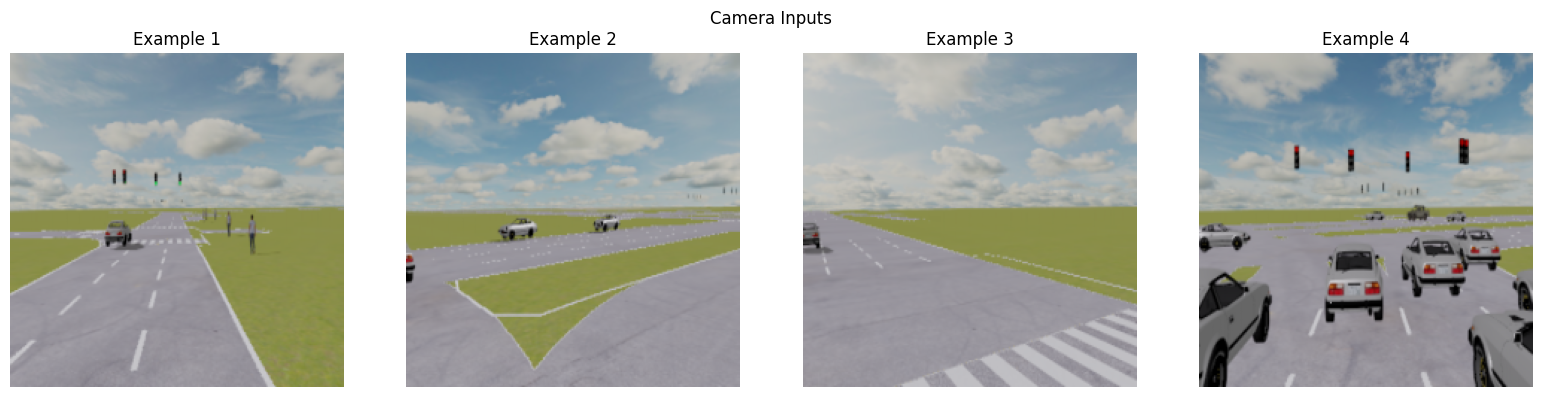

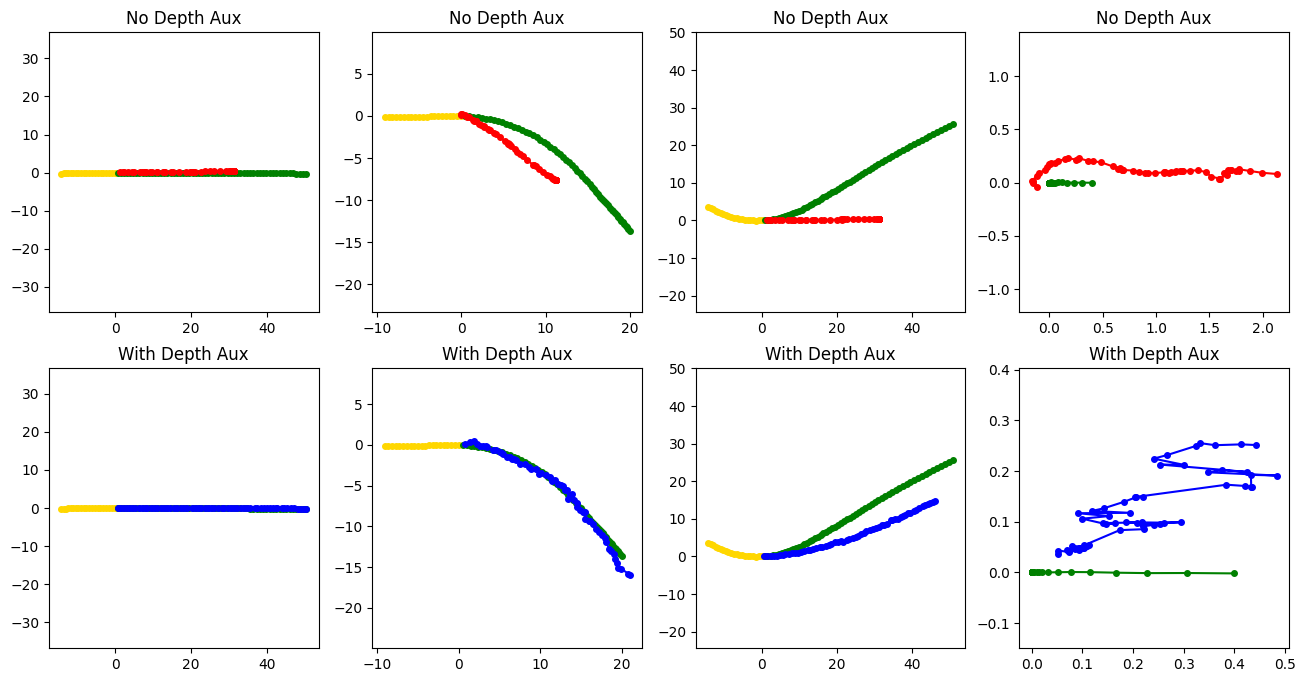

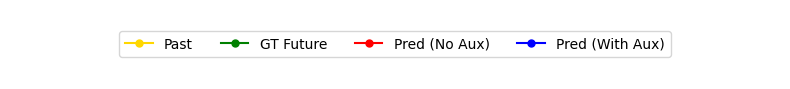

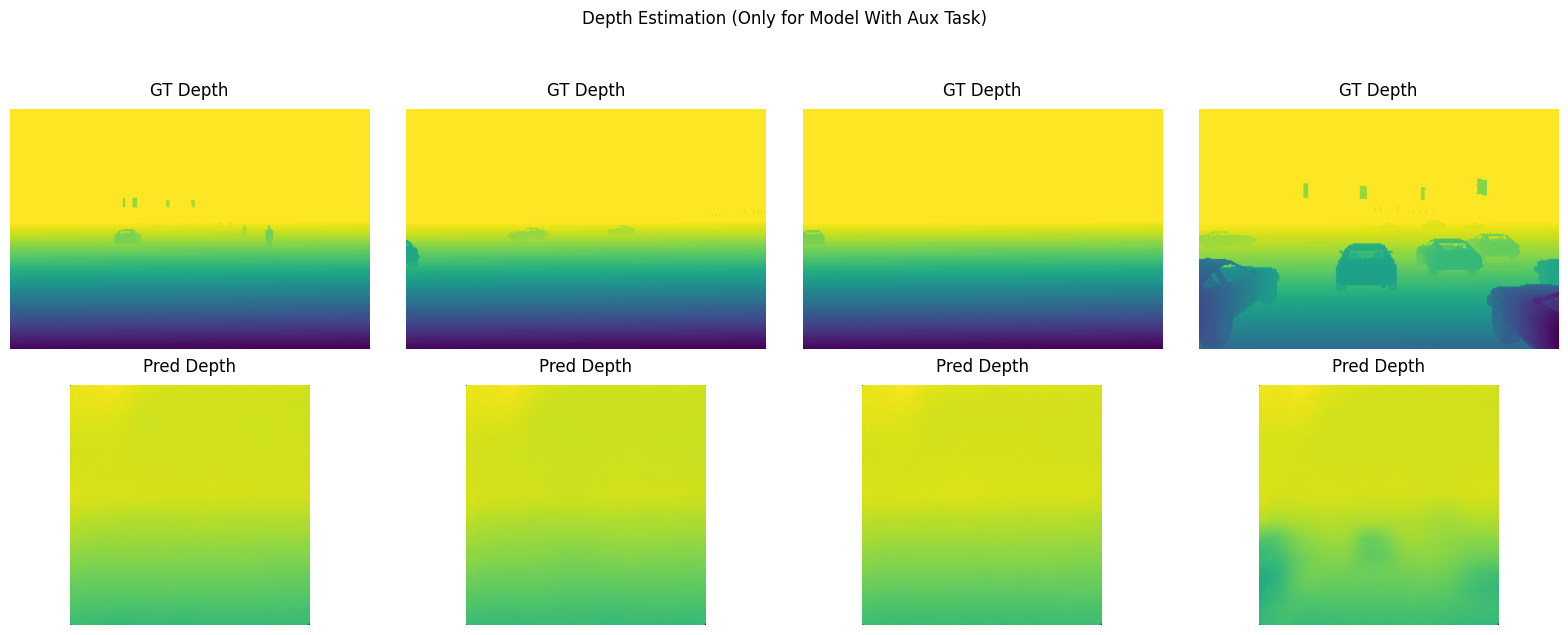

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
visualize_comparison(val_loader, model_no_aux, model_with_aux, device)


Now we run our model on the test set once, to get the plan of our model and save it for submission. Notice that the ground truth plans are removed for the test set, so you can not calculate the ADE metric on the test set yourself, and need to submit it to the leader board. By running the last cell, you'll be able to see a csv file called submission_phase2.csv by clicking on the folder icon on the left. Download it and submit it to the leaderboard to get your score.

In [ ]:
with open(f"test_public/0.pkl", "rb") as f:
    data = pickle.load(f)
print(data.keys())
# Note the absence of sdc_future_feature

dict_keys(['camera', 'depth', 'driving_command', 'sdc_history_feature', 'semantic_label'])


In [ ]:
import pandas as pd
test_data_dir = "test_public"
test_files = [os.path.join(test_data_dir, fn) for fn in sorted([f for f in os.listdir(test_data_dir) if f.endswith(".pkl")], key=lambda fn: int(os.path.splitext(fn)[0]))]
test_dataset = DrivingDataset(test_files, test=True)
test_loader = DataLoader(test_dataset, batch_size=250, num_workers=2)
model_with_aux.eval()
all_plans = []

with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)

        outputs = model_with_aux(camera, history)  # returns a dict
        pred_future = outputs['trajectory']  # [B, 1, 60, 3]
        pred_future = pred_future.squeeze(1)  # [B, 60, 3]

        all_plans.append(pred_future.cpu().numpy()[..., :2])  # get x, y only

all_plans = np.concatenate(all_plans, axis=0)


# Now save the plans as a csv file
# Extract only x and y from predictions
pred_xy = all_plans[..., :2]  # shape: (total_samples, K, T, 2) or (total_samples, T, 2)

# ✅ Reduce from multi-modal [B, K, T, 2] to single-mode [B, T, 2] if needed
if pred_xy.ndim == 4:
    pred_xy = pred_xy[:, 0]  # Use the first mode (you can change this to best mode later)
# shape: (total_samples, T, 2)

# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape
pred_xy_flat = pred_xy.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

# Save to CSV
df_xy.to_csv("submission_phase2.csv", index=False)

print(f"Shape of df_xy: {df_xy.shape}")

Shape of df_xy: (1000, 121)
